# Sieci neuronowe i Deep Learning
# Temat 8: Konwolucyjne sieci neuronowe

## Zadanie 8.1

Przeanalizować poniższą konstrukcję i uczenie sieci CNN do rozpoznawania odręcznie pisanych cyfr na podstawie zbioru danych MNIST.

Architektura sieci:

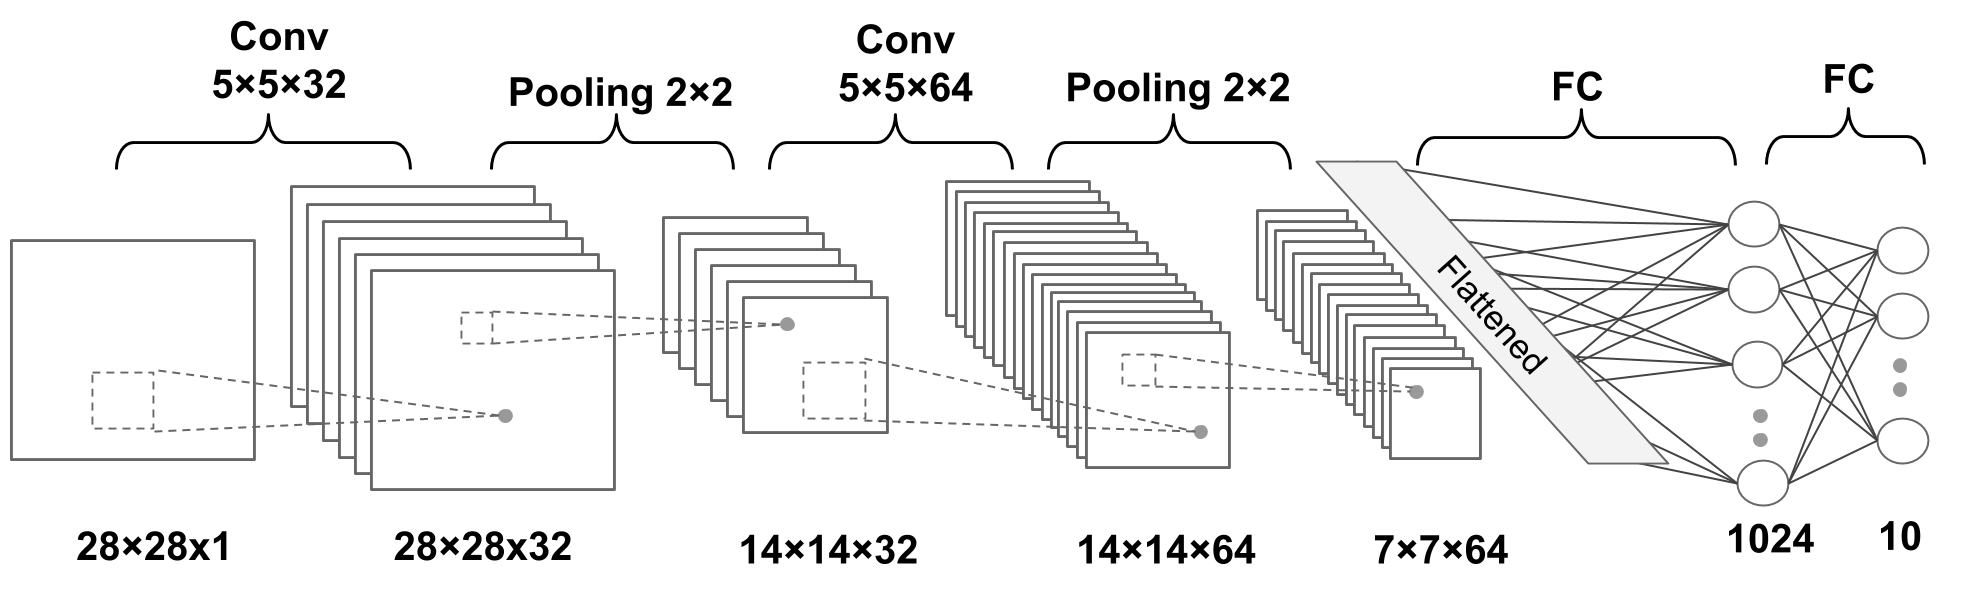

In [134]:
from IPython.display import Image
%matplotlib inline

Image(filename='cnn_mnist.png')

Wczytanie danych MNIST (tak samo jak na wykładzie 3):

In [135]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

Tworzymy zbiory: treningowy, walidacyjny, testowy:

In [136]:
import torch

from torch.utils.data import Subset

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

Tworzymy dataloadery dla zbiorów treningowego i walidacyjnego:

In [137]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

#### W module `torch.nn` dostępne są klasy dla standardowych składowych sieci konwolucyjnych:

 * **Conv2d:** `torch.nn.Conv2d`
   * `out_channels` - liczba kanałów wyjściowych (= liczba map cech)
   * `kernel_size`
   * `stride` - domyślnie ustawiony na 1
   * `padding`

`Conv2D` zakłada, że wejście jest w formacie
NCHW (liczba kanałów obrazu jest w pierwszym lub drugim (jeśli uwzględniamy rozmiar wsadu) wymiarze tensora wejściowego);
NChannelsHeightWidth.
   
   
 * **MaxPool2d:** `torch.nn.MaxPool2d`
   * `kernel_size` - rozmiar okna, z którego będzie liczona odpowiednia statystyka
   * `stride` - domyślnie ustawiany na kernel size
   * `padding`
   
   
 * **Dropout** `torch.nn.Dropout`
   * `p` - prawdopodobieństwo wyłączenia neuronu (sygnału wejściowego) podczas uczenia

### Konstrukcja sieci CNN w PyTorch

Używamy klasy `Sequential` z `torch.nn`. Dodajmy warstwy konwolucyjne oraz pooling:

In [138]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

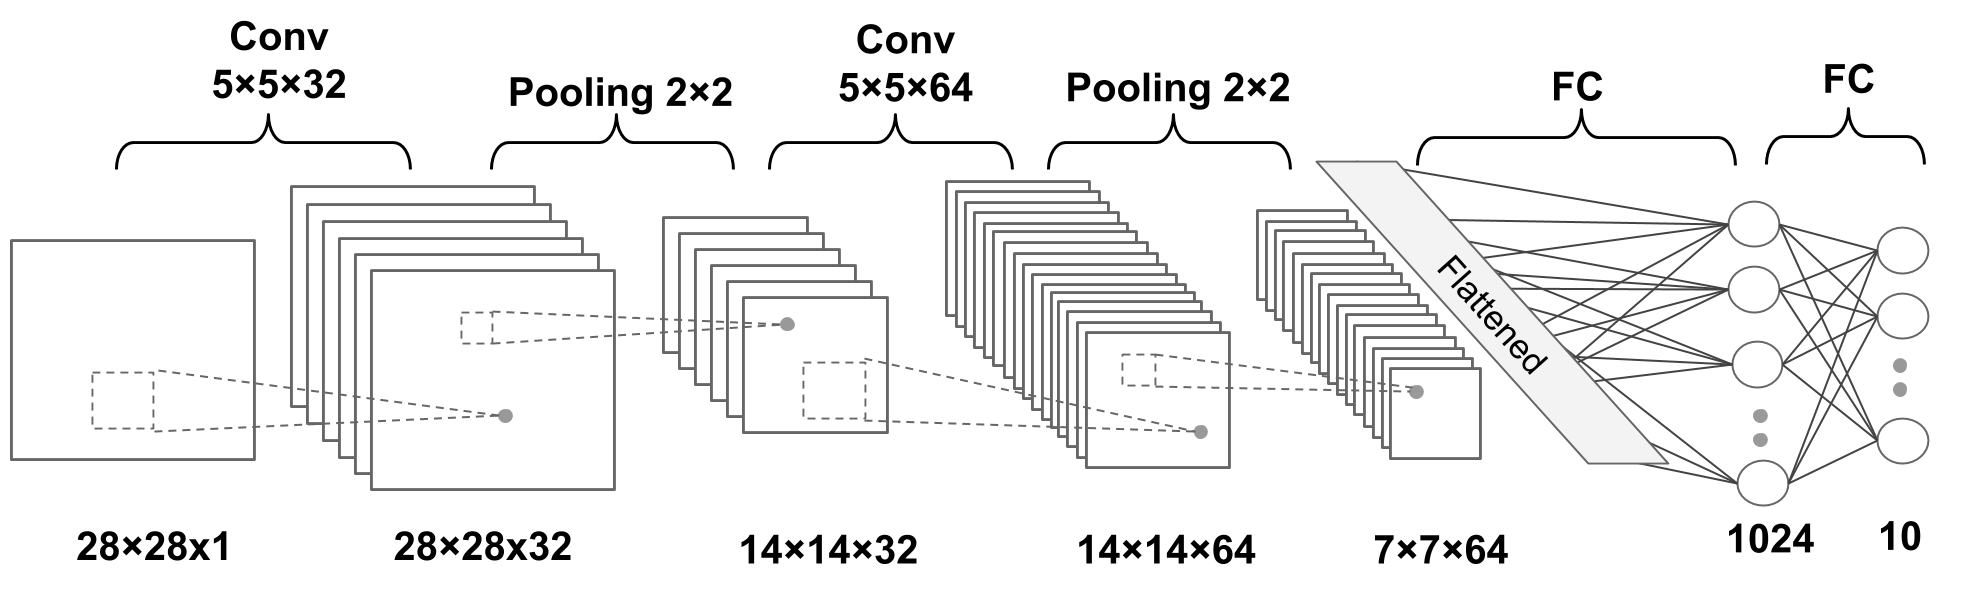

In [139]:
Image(filename='cnn_mnist.png', width = 600)

In [140]:
# Liczenie rozmiaru wyjścia z powyższego modelu:
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

Dane wejściowe do kolejnej warstwy (FC) muszą mieć rząd 2
([batchsize × input_units]). Spłaszczamy wyjście z poprzednich warstw:

In [141]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

Dodajmy dwie warstwy typu *fully connected* z warstwą *dropout* pomiędzy:

In [142]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))  # 10 dla 10 etykiet

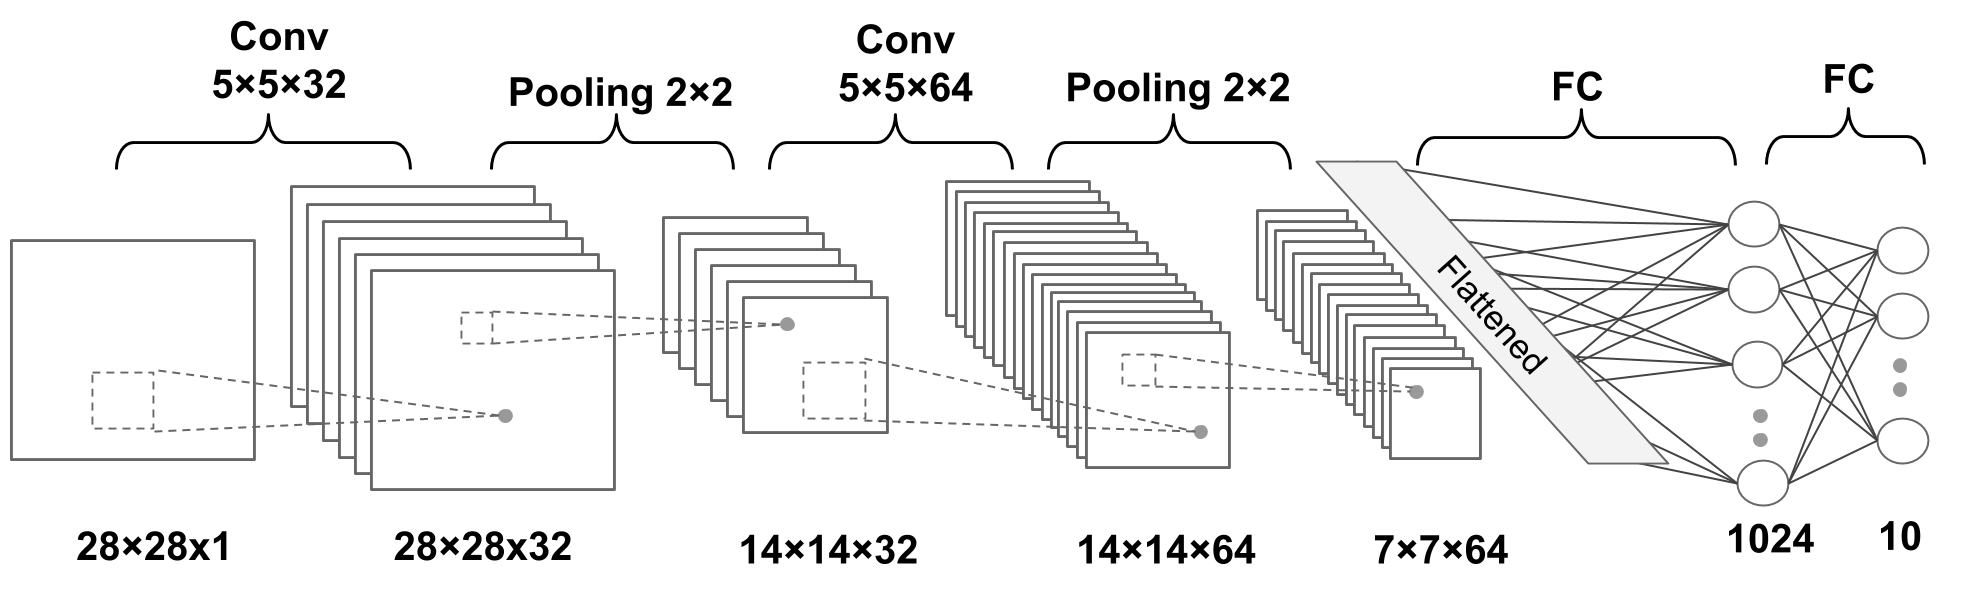

In [143]:
Image(filename='cnn_mnist.png', width = 600)

W implementacji `CrossEntropyLoss` (w PyTorch) domyślnie używana jest funkcja aktywacji softmax, dlatego nie trzeba dodawać jej jawnie jako warstwy wyjściowej powyżej.

In [144]:
# Ustawienie urządzenia (device),
# na którym będzie wykonywany model sieci neuronowej
# i przesłanie tego modelu na wybrane urządzenie:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # na pierwsze dostępne GPU
# device = torch.device("cpu")

model = model.to(device)

Wybieramy funkcję straty oraz optymalizator:

In [145]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Definiujemy funkcję train:

In [146]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

Uruchamiamy uczenie:

In [147]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9501 val_accuracy: 0.9809
Epoch 2 accuracy: 0.9837 val_accuracy: 0.9859
Epoch 3 accuracy: 0.9897 val_accuracy: 0.9869
Epoch 4 accuracy: 0.9924 val_accuracy: 0.9897
Epoch 5 accuracy: 0.9929 val_accuracy: 0.9893
Epoch 6 accuracy: 0.9945 val_accuracy: 0.9900
Epoch 7 accuracy: 0.9948 val_accuracy: 0.9904
Epoch 8 accuracy: 0.9962 val_accuracy: 0.9880
Epoch 9 accuracy: 0.9964 val_accuracy: 0.9901
Epoch 10 accuracy: 0.9963 val_accuracy: 0.9893
Epoch 11 accuracy: 0.9967 val_accuracy: 0.9906
Epoch 12 accuracy: 0.9972 val_accuracy: 0.9905
Epoch 13 accuracy: 0.9979 val_accuracy: 0.9913
Epoch 14 accuracy: 0.9979 val_accuracy: 0.9918
Epoch 15 accuracy: 0.9979 val_accuracy: 0.9915
Epoch 16 accuracy: 0.9979 val_accuracy: 0.9900
Epoch 17 accuracy: 0.9987 val_accuracy: 0.9909
Epoch 18 accuracy: 0.9981 val_accuracy: 0.9900
Epoch 19 accuracy: 0.9980 val_accuracy: 0.9903
Epoch 20 accuracy: 0.9981 val_accuracy: 0.9898


Wykresy krzywych uczenia:

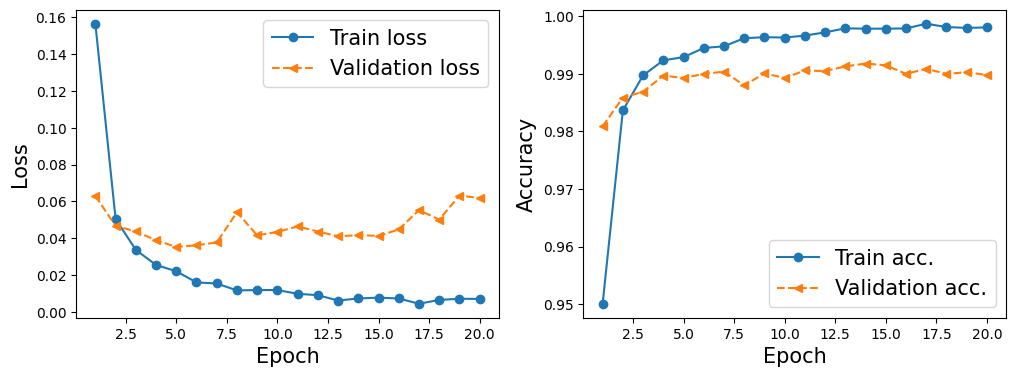

In [148]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

Sprawdzenie modelu na zbiorze testowym:

In [149]:
# Jeśli liczyliśmy na GPU, to synchronizujemy wszystkie operacje CUDA
# oraz przenosimy model z GPU na CPU:
torch.cuda.synchronize()
model_cpu = model.cpu()

pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9938


12 przykładów ze zbioru testowego wraz z predykcjami:

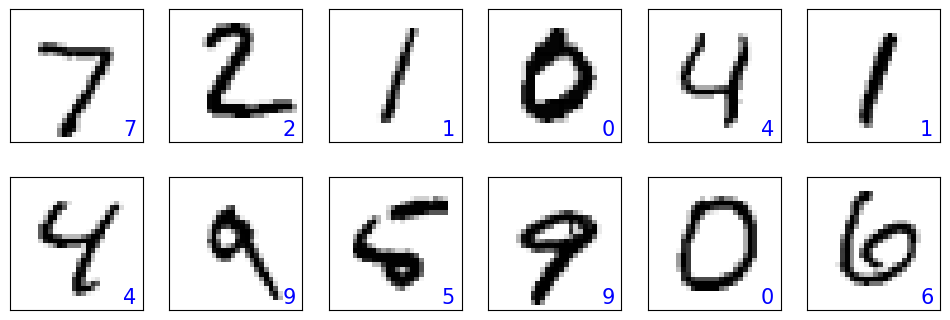

In [150]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

plt.show()

In [151]:
# Zapisanie modelu do pliku:

import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)

## Zadanie 8.2

Narysować przykładowe przykłady (wybrane ze zbioru testowego), które zostały sklasyfikowane błędnie.

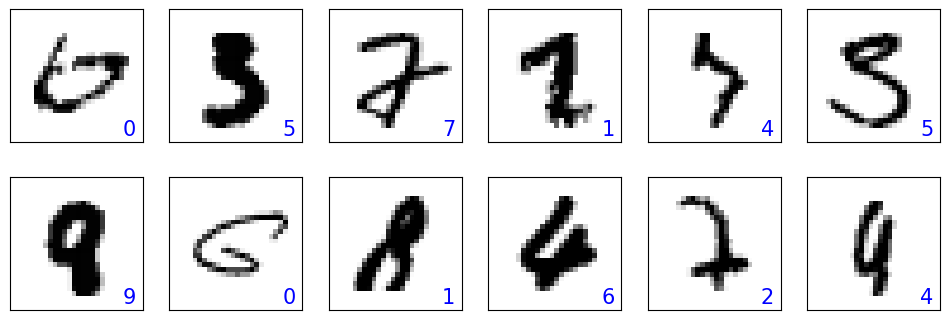

In [152]:
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets)
misclassified_indices = torch.nonzero(is_correct == 0).squeeze()
predictions = torch.argmax(pred, dim=1)
predictions_misclassified = predictions[misclassified_indices]
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[misclassified_indices[i]][0][0, :, :]
    y_pred = predictions_misclassified[i]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

## Zadanie 8.3

Zaprojektować inną architekturę sieci i przeprowadzić jej uczenie oraz sprawdzenie na zbiorze testowym. Porównać otrzymane wyniki do sieci skonstruowanej w ramach zadania 8.1.

In [153]:
model2 = nn.Sequential()
model2.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1))
model2.add_module('relu1', nn.ReLU())
model2.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model2.add_module('relu2', nn.ReLU())
model2.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model2.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model2.add_module('relu3', nn.ReLU())
model2.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model2.add_module('flatten', nn.Flatten())
model2.add_module('fc1', nn.Linear(128 * 7 * 7, 256))
model2.add_module('relu4', nn.ReLU())
model2.add_module('dropout', nn.Dropout(p=0.5))
model2.add_module('fc2', nn.Linear(256, 10))

In [154]:
model2 = model2.to(device)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
loss_fn2 = nn.CrossEntropyLoss()

In [155]:
def train2(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn2(pred, y_batch)
            loss.backward()
            optimizer2.step()
            optimizer2.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn2(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [156]:
torch.manual_seed(1)
hist2 = train2(model2, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9397 val_accuracy: 0.9818
Epoch 2 accuracy: 0.9808 val_accuracy: 0.9850
Epoch 3 accuracy: 0.9864 val_accuracy: 0.9869
Epoch 4 accuracy: 0.9890 val_accuracy: 0.9891
Epoch 5 accuracy: 0.9903 val_accuracy: 0.9891
Epoch 6 accuracy: 0.9919 val_accuracy: 0.9885
Epoch 7 accuracy: 0.9927 val_accuracy: 0.9889
Epoch 8 accuracy: 0.9937 val_accuracy: 0.9905
Epoch 9 accuracy: 0.9938 val_accuracy: 0.9910
Epoch 10 accuracy: 0.9951 val_accuracy: 0.9904
Epoch 11 accuracy: 0.9956 val_accuracy: 0.9909
Epoch 12 accuracy: 0.9957 val_accuracy: 0.9917
Epoch 13 accuracy: 0.9963 val_accuracy: 0.9913
Epoch 14 accuracy: 0.9964 val_accuracy: 0.9921
Epoch 15 accuracy: 0.9973 val_accuracy: 0.9903
Epoch 16 accuracy: 0.9967 val_accuracy: 0.9918
Epoch 17 accuracy: 0.9973 val_accuracy: 0.9928
Epoch 18 accuracy: 0.9972 val_accuracy: 0.9921
Epoch 19 accuracy: 0.9971 val_accuracy: 0.9916
Epoch 20 accuracy: 0.9977 val_accuracy: 0.9910


In [158]:
torch.cuda.synchronize()
model2_cpu = model2.cpu()

In [159]:
pred2 = model2(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct2 = (torch.argmax(pred2, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy (new model): {is_correct2.mean():.4f}')

Test accuracy (new model): 0.9941
